# Lesson 5 Assignment: Tumor Classification with Decision Trees
## Author: Dustin Burham
### Due August 11th, 2019

Rooney's client is a tech-manufacturing startup working on a number of automated detection devices for the medical and construction industries. Among the auto-detection devices is a reader that looks at possible carcinoma tissue samples to classify the sample as either benign or malignant. Rooney asks you for help in developing a better algorithm than the current classifier, perhaps a decision tree can help.

1. Test both entropy and the gini coefficient. Which performs better and why?
2. What are the best hyperparameter settings for both?
3. Visualize both models and see which feature is selected for each criterion. Are they same for both? Why or why not?
4. Determine the AUC for the best model you can achieve. What are the precision and recal values and which might be the one you want to maximize?
5. What are the implications of using this type of machine learning algorithm for breast cancer analysis?

In [1]:
# Import libraries
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn import metrics
from sklearn.metrics import *

### Read in the data

In [2]:
names = ['id', 'clump_thickness', 'uniformity_size', 'uniformity_shape', 
         'marginal_adhesion', 'single_epithelial_cell_size', 'bare_nuclei', 
         'bland_chromatin', 'normal_nucleoli', 'mitosis', 'class']
bc = pd.read_csv("breast-cancer-wisconsin.data", names=names)

In [3]:
bc.head()

,id,clump_thickness,uniformity_size,uniformity_shape,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitosis,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [4]:
bc.dtypes

id                              int64
clump_thickness                 int64
uniformity_size                 int64
uniformity_shape                int64
marginal_adhesion               int64
single_epithelial_cell_size     int64
bare_nuclei                    object
bland_chromatin                 int64
normal_nucleoli                 int64
mitosis                         int64
class                           int64
dtype: object

In [5]:
# Bare nuclei have '?', drop rows with those values
bc['bare_nuclei'] = pd.to_numeric(bc['bare_nuclei'], errors='coerce')
bc = bc.dropna() 

In [6]:
# Check for label imbalance
np.unique(bc['class'], return_counts=True)

(array([2, 4]), array([444, 239]))

In [7]:
bc.describe()

,id,clump_thickness,uniformity_size,uniformity_shape,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitosis,class
count,6.830000e+02,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,1.076720e+06,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,1.603221,2.699854
std,6.206440e+05,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,1.732674,0.954592
min,6.337500e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.776170e+05,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171795e+06,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238705e+06,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [8]:
# Change positive to 1, negative to 0
bc.loc[bc['class'] == 4,'class'] = 1
bc.loc[bc['class'] == 2,'class'] = 0
X = bc.iloc[:, 1:10]
Y = bc.iloc[:, 10]

In [9]:
# Split train, test data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state=1)

### 1, 2). Test both entropy and the gini coefficient. Which performs better and why?   What are the best hyperparameter settings for both?

In [10]:
# This probably isn't the best way to test hyper parameters,
# but I will loop throught the following values and picks
# the hyperparameter values that maximize accuracy.
max_depth = [1, 2, 3, 4, 5, 6, 7, 8]
max_leaves = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Each function saves accuracy (value) to the corresponding
# key (hyperparamter value) for comparison.
def hyper_param_max_depth(param):
    accuracy_ent = {}
    accuracy_gini = {}
    
    for i in param:
        # entropy
        model_ent = DecisionTreeClassifier(max_depth = i, criterion = 'entropy')
        model_ent.fit(X_train, y_train)
        y_ent_pred = model_ent.predict(X_test)
        accuracy_ent[i] = accuracy_score(y_test, y_ent_pred)*100

        # gini
        model_gini = DecisionTreeClassifier(max_depth = i)
        model_gini.fit(X_train, y_train)
        y_gini_pred = model_gini.predict(X_test)
        accuracy_gini[i] = accuracy_score(y_test, y_gini_pred)*100
    return(accuracy_ent, accuracy_gini)

def hyper_param_max_leaves(param):
    accuracy_ent = {}
    accuracy_gini = {}
    
    for i in param:
        # entropy
        model_ent = DecisionTreeClassifier(max_leaf_nodes = i, criterion = 'entropy')
        model_ent.fit(X_train, y_train)
        y_ent_pred = model_ent.predict(X_test)
        accuracy_ent[i] = accuracy_score(y_test, y_ent_pred)*100

        # gini
        model_gini = DecisionTreeClassifier(max_leaf_nodes = i)
        model_gini.fit(X_train, y_train)
        y_gini_pred = model_gini.predict(X_test)
        accuracy_gini[i] = accuracy_score(y_test, y_gini_pred)*100
    return(accuracy_ent, accuracy_gini)

In [11]:
accuracy_ent,accuracy_gini = hyper_param_max_depth(max_depth)

In [12]:
# Max depth: Accuracy
# 5 as a max depth maximizes the accuracy for entropy model
accuracy_ent

{1: 92.19512195121952,
 2: 92.19512195121952,
 3: 95.60975609756098,
 4: 95.60975609756098,
 5: 95.60975609756098,
 6: 94.6341463414634,
 7: 95.60975609756098,
 8: 94.6341463414634}

In [13]:
# Max depth: Accuracy
# 5 as a max depth maximizes the accuracy for gini model
accuracy_gini

{1: 92.19512195121952,
 2: 95.1219512195122,
 3: 94.6341463414634,
 4: 96.09756097560975,
 5: 97.07317073170731,
 6: 96.09756097560975,
 7: 96.09756097560975,
 8: 96.09756097560975}

In [14]:
accuracy_ent,accuracy_gini = hyper_param_max_leaves(max_leaves)

In [15]:
# Max leaves: Accuracy
# 6 as a max leaves maximizes the accuracy for entropy model
accuracy_ent

{2: 92.19512195121952,
 3: 92.19512195121952,
 4: 92.19512195121952,
 5: 94.6341463414634,
 6: 95.60975609756098,
 7: 95.60975609756098,
 8: 95.60975609756098,
 9: 95.60975609756098,
 10: 95.60975609756098}

In [16]:
# Max leaves: Accuracy
# 7 as a max leaves maximizes the accuracy for gini model
accuracy_gini

{2: 92.19512195121952,
 3: 95.1219512195122,
 4: 95.60975609756098,
 5: 94.6341463414634,
 6: 95.60975609756098,
 7: 96.09756097560975,
 8: 96.09756097560975,
 9: 96.09756097560975,
 10: 96.09756097560975}

The hyper parameter values for max depth and max number of leaves that create the best accuracy for predictions are:

Max Depth -> 5

Max Number of Leaves -> 7

### Entropy or Gini?
Test the hyperparameters above on both gini and entropy
decision tree models for comparison.  I will use the f1 score on both test and train sets to look for over/under fitting.

In [17]:
# Entropy
model_ent = DecisionTreeClassifier(max_leaf_nodes = 7, max_depth=5, criterion = 'entropy')
model_ent.fit(X_train, y_train)
y_ent_pred = model_ent.predict(X_test)

# Gini
model_gini = DecisionTreeClassifier(max_leaf_nodes = 7, max_depth=5)
model_gini.fit(X_train, y_train)
y_gini_pred = model_gini.predict(X_test)

In [18]:
print("Entropy accuracy is : {}%".format(accuracy_score(y_test, y_ent_pred)*100))
print("Gini accuracy is : {}%".format(accuracy_score(y_test, y_gini_pred)*100))

Entropy accuracy is : 95.60975609756098%
Gini accuracy is : 96.09756097560975%


In [19]:
# Generate predictions for both entropy, gini models using 
# train and test data
y_train_ent_pred = model_ent.predict(X_train)
y_train_gini_pred = model_gini.predict(X_train)
y_test_ent_pred = model_ent.predict(X_test)
y_test_gini_pred = model_gini.predict(X_test)

In [20]:
# Compare the accuracy between the different models, and the
# set of data used in the training.
res = pd.DataFrame(columns = ["criteria", "data", "metric"])
res.loc[0, :] = ["entropy", "train", f1_score(y_train, y_train_ent_pred)]
res.loc[1, :] = ["entropy", "test", f1_score(y_test, y_ent_pred)]
res.loc[2, :] = ["gini", "train", f1_score(y_train, y_train_gini_pred)]
res.loc[3, :] = ["gini", "test", f1_score(y_test, y_gini_pred)]
res

,criteria,data,metric
0,entropy,train,0.961424
1,entropy,test,0.939597
2,gini,train,0.97076
3,gini,test,0.945946


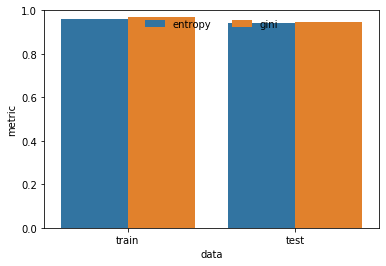

In [21]:
bp = sns.barplot(x =  "data", hue = "criteria", y = "metric", data = res)
bp.legend(frameon = False, loc = "upper center", ncol = 2)
bp.set_ylim(0, 1)
bp

### Summary:
Both the Entropy and Gini models are overfitting when choosing the max depth and max number of leaves that maximizes accuracy, which I guess is not surprising.  I investegated further by playing with the hyperparamters to try and achieve balance, but the results were still overfit when observing the f1 score of the two models trained on the train and test data. Because the gini model has higher accuracy for both train and test sets, while being about as overfit as the entropy model, I will move forward with the gini model.  However, as we will see in the next section, the entropy decision tree is much less one sided than the gini decision tree.

### 3. Visualize both models and see which feature is selected for each criterion. Are they same for both? Why or why not?

In [ ]:
from sklearn import tree
import os
dotfile = open("dtree.dot", 'w')
tree.export_graphviz(model_gini, out_file = dotfile, feature_names = names[1:10])
dotfile.close()
os.environ["PATH"] += os.pathsep + '/Users/dusty/anaconda3/pkgs/graphviz-2.40.1-hefbbd9a_2/lib/graphviz'
os.system('dot -Tpng dtree.dot -o dtree.png')

In [22]:
from sklearn import tree
dotfile = open("dtree.dot", 'w')
dotfile2 = open("dtree2.dot", 'w')
tree.export_graphviz(model_gini, out_file = dotfile, feature_names = names[1:10])
tree.export_graphviz(model_ent, out_file = dotfile2, feature_names = names[1:10])
dotfile.close()
dotfile2.close()

In [23]:
import os
os.environ["PATH"] += os.pathsep + '/Users/dusty/anaconda3/pkgs/graphviz-2.40.1-hefbbd9a_2/lib/graphviz'
os.system('dot -Tpng dtree.dot -o dtree.png')
os.system('dot -Tpng dtree2.dot -o dtree2.png')

0

### Gini  Model Tree

<img src="dtree.png">

### Entropy Model

<img src="dtree2.png">

The features selected in the gini model are slightly different in location than the entropy model, but the total set of selective features is the same.  The factors that share the same level are uniformity_size (most important), and clump thickness.  The differences that are most noticable are where the features used are.  Features like bare_nuclei and normal_nuclei are in both, but appear in differnt places in the tree.  Both models appear to do well, but the gini model has a tree that isn't split as evenly (bare_nuclei).  However, the gini tree does a better job of predicting benign or malignant.

### 4. Determine the AUC for the best model you can achieve. What are the precision and recal values and which might be the one you want to maximize?

In [24]:
CM = metrics.confusion_matrix(y_test, y_gini_pred)
tn, fp, fn, tp = CM.ravel()

In [25]:
print(list(set(y_test)))

[0, 1]


In [26]:
print('True Negative: ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)
print('True Positive: ', tp)

True Negative:  127
False Positive:  6
False Negative:  2
True Positive:  70


Area Under Curve: 0.9635547201336675


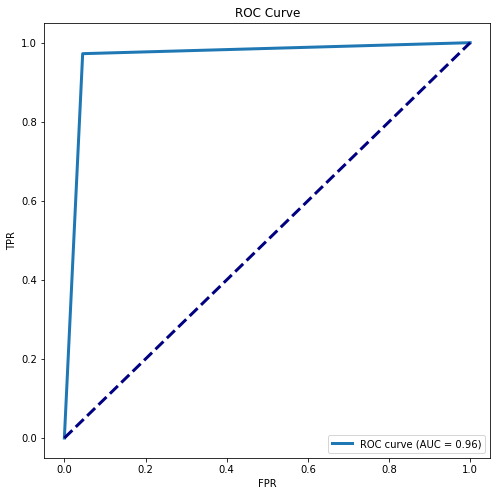

In [27]:
# Generate True Positive Rate, Fale Positive Rate
fpr, tpr, th = roc_curve(y_test, y_gini_pred)

# Generate Area Under the ROC Curve
AUC = auc(fpr, tpr)
print("Area Under Curve:", AUC)

# Generate ROC Plot
plt.rcParams["figure.figsize"] = [8, 8] # Square
plt.figure()
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(fpr, tpr, LW=3, label='ROC curve (AUC = %0.2f)' % AUC)
plt.plot([0, 1], [0, 1], color='navy', LW=3, linestyle='--') # reference line for random classifier
plt.legend(loc="lower right")
plt.show()

In [28]:
precision = precision_score(y_test, y_gini_pred)
print("precision:", precision)
recall = recall_score(y_test, y_gini_pred)
print("recall:", recall)

precision: 0.9210526315789473
recall: 0.9722222222222222


#### What are the precision and recal values and which might be the one you want to maximize?

Precision: 0.92

Recall 0.97

Because we are working with a serious classification, whether or not a person has breast cancer, we would rather have more false positives than false negatives.  If a tumer is labeled positive, but it actually negative, a followup test would most likely provide the correct label of benign.  However, if a tumer is labeled as benign when it is not, that person will be in serious harm in the near future.  As a result we will want to maximize recall.  Recall is the fraction of true positive identified divided by the ground truth number of positive tumors.  If we maximize this, then that means a small number of true positive are slipping through the cracks.  Looking at the recall for this model, I believe that our model will do a good job of having a small number of false positives, and we can see this by looking at the confusin matrix.  

### 5. What are the implications of using this type of machine learning algorithm for breast cancer analysis?

The gini decision tree algorithm does a good job of classifying whether a tumor is dangerous or not, with an accuracy of 96.1% and a recall of 97%.  However, because this is a "high stakes" model, where a misclassification can mean life or death for an individual, we should use a more complicated model that has higher accuracy and recall.  I'm sure the models we will learn about this week (embedded models) will provide a better results.